# Assignment 5 – fine-tune a pretrained YOLO model on MNISTDD-RGB

In [1]:
!pip -q install torch torchvision

In [2]:
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Part A (In-Lab 2%)

## Loading the dataset

Google Drive dataset link for convenience: https://drive.google.com/drive/folders/1LclUCgK7JFVRU_oDQGQ-PH22YQTxc2kT

In [3]:
local_path = '/content/drive'
remote_path = 'MyDrive/Rosie/'

from google.colab import drive
from pathlib import Path

drive.mount(local_path)

Mounted at /content/drive


In [4]:
train_zip = np.load(Path(local_path) / Path(remote_path) / 'train.npz')
train_images = torch.tensor(train_zip["images"])
train_labels = torch.tensor(train_zip["labels"])
train_bboxes = torch.tensor(train_zip["bboxes"])

val_zip = np.load(Path(local_path) / Path(remote_path) / 'valid.npz')
val_images = torch.tensor(val_zip["images"])
val_labels = torch.tensor(val_zip["labels"])
val_bboxes = torch.tensor(val_zip["bboxes"])

print(f"Number of images for:\n\tTraining:\t{train_images.shape[0]}\n\tValidation:\t{val_images.shape[0]}")

Number of images for:
	Training:	55000
	Validation:	5000


In [5]:
print(train_images[0].shape, train_labels[0].shape, train_bboxes[0].shape, sep="\n")

torch.Size([12288])
torch.Size([2])
torch.Size([2, 4])


### Image and bbox visualization

In [6]:
def show_image_and_bboxes(image, bboxes=None, labels=None):
    """
    Display image with bounding boxes and labels.
    Assumes image is flattened 12288 values (64x64x3 RGB)
    """
    # Reshape flattened image to 64x64x3 (RGB)
    image_reshaped = image.reshape(64, 64, 3)

    # Normalize to 0-1 range if needed
    if image_reshaped.max() > 1.0:
        image_reshaped = image_reshaped / 255.0

    plt.figure(figsize=(8, 8))
    plt.imshow(image_reshaped)
    ax = plt.gca()

    if bboxes is not None:
        for i, bbox in enumerate(bboxes):
            # Skip invalid bboxes (all zeros or negative values)
            if torch.all(bbox == 0) or torch.any(bbox < 0):
                continue

            x_min, y_min, x_max, y_max = bbox.tolist()
            width = x_max - x_min
            height = y_max - y_min

            # Only draw if bbox has positive dimensions
            if width > 0 and height > 0:
                rect = plt.Rectangle((x_min, y_min), width, height,
                                   fill=False, color='red', linewidth=2)
                ax.add_patch(rect)

                # Add label if available
                if labels is not None and i < len(labels):
                    ax.text(x_min, y_min-5, f'Class: {labels[i].item()}',
                           bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 2},
                           fontsize=10, color='red')

    plt.title('Sample Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

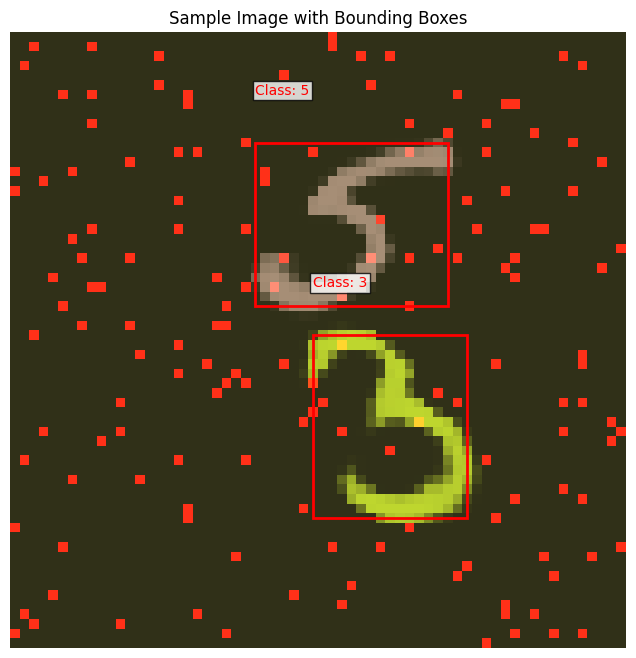

In [7]:
# plot figure
# Select an image and its corresponding labels and bounding boxes from the training set
some_image_idx = 0 # You can change this index to visualize different images
some_image = train_images[some_image_idx]
some_bboxes = train_bboxes[some_image_idx]
some_labels = train_labels[some_image_idx]

# Display the image with bounding boxes and labels
show_image_and_bboxes(some_image, some_bboxes, some_labels)

### Prepare dataset for training

Subset of training data created with size: 10000


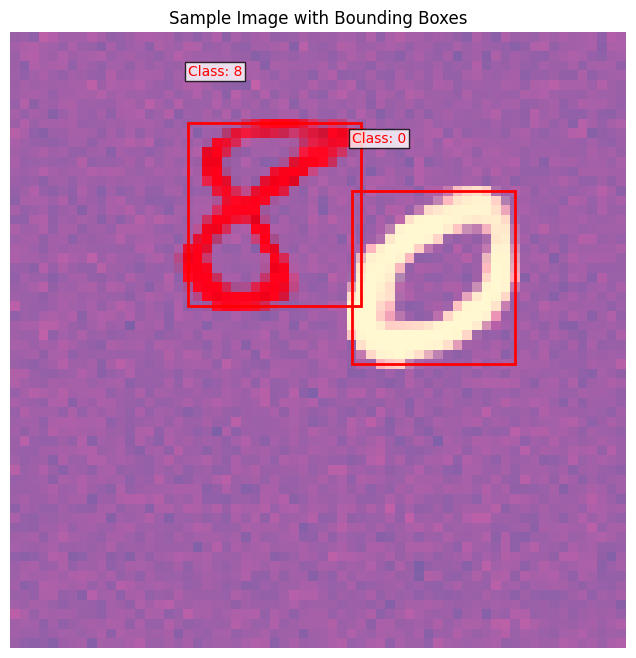

In [8]:
# TODO: prepare dataset
# prepare dataset block learned from chenqi yang
# Select a subset of approximately 10,000 images from the training data
subset_size = 10000
train_images_subset = train_images[:subset_size]
train_labels_subset = train_labels[:subset_size]
train_bboxes_subset = train_bboxes[:subset_size]

print(f"Subset of training data created with size: {subset_size}")

# Select a sample from the subset for visualization
some_image_idx_subset = 4324
some_image_subset = train_images[:subset_size][some_image_idx_subset]
some_bboxes_subset = train_bboxes[:subset_size][some_image_idx_subset]
some_labels_subset = train_labels[:subset_size][some_image_idx_subset]

# Display the sample from the subset
show_image_and_bboxes(some_image_subset, some_bboxes_subset, some_labels_subset)

In [9]:
import os

# Define the base directory for the dataset
dataset_base_dir = '/content/mnistdd_yolo'

# Define directories for images and labels
train_images_dir = os.path.join(dataset_base_dir, 'images', 'train')
train_labels_dir = os.path.join(dataset_base_dir, 'labels', 'train')
val_images_dir = os.path.join(dataset_base_dir, 'images', 'val')
val_labels_dir = os.path.join(dataset_base_dir, 'labels', 'val')

# Create directories if they don't exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

print(f"Created dataset directories in {dataset_base_dir}")

Created dataset directories in /content/mnistdd_yolo


In [10]:
from PIL import Image
import torch
import os
from tqdm import tqdm

# Function to convert bounding box to YOLO format
def convert_to_yolo_format(bbox, image_width, image_height):
    """Converts a bounding box from [x_min, y_min, x_max, y_max] to YOLO format [center_x, center_y, width, height]."""
    x_min, y_min, x_max, y_max = bbox.tolist()

    center_x = ((x_min + x_max) / 2.0) / image_width
    center_y = ((y_min + y_max) / 2.0) / image_height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height

    return [center_x, center_y, width, height]

# Assuming image dimensions are 64x64
image_width = 64
image_height = 64

# Define base directories for both datasets
dataset_base_dir_subset = '/content/mnistdd_yolo_subset'
dataset_base_dir_full = '/content/mnistdd_yolo_full'

# Define directories for images and labels for the subset
train_images_dir_subset = os.path.join(dataset_base_dir_subset, 'images', 'train')
train_labels_dir_subset = os.path.join(dataset_base_dir_subset, 'labels', 'train')
val_images_dir_subset = os.path.join(dataset_base_dir_subset, 'images', 'val') # Validation data is the same
val_labels_dir_subset = os.path.join(dataset_base_dir_subset, 'labels', 'val') # Validation data is the same

# Define directories for images and labels for the full dataset
train_images_dir_full = os.path.join(dataset_base_dir_full, 'images', 'train')
train_labels_dir_full = os.path.join(dataset_base_dir_full, 'labels', 'train')
val_images_dir_full = os.path.join(dataset_base_dir_full, 'images', 'val') # Validation data is the same
val_labels_dir_full = os.path.join(dataset_base_dir_full, 'labels', 'val') # Validation data is the same


# Create directories if they don't exist for subset
os.makedirs(train_images_dir_subset, exist_ok=True)
os.makedirs(train_labels_dir_subset, exist_ok=True)
os.makedirs(val_images_dir_subset, exist_ok=True)
os.makedirs(val_labels_dir_subset, exist_ok=True)

# Create directories if they don't exist for full dataset
os.makedirs(train_images_dir_full, exist_ok=True)
os.makedirs(train_labels_dir_full, exist_ok=True)
os.makedirs(val_images_dir_full, exist_ok=True)
os.makedirs(val_labels_dir_full, exist_ok=True)

print(f"Created dataset directories for subset in {dataset_base_dir_subset}")
print(f"Created dataset directories for full dataset in {dataset_base_dir_full}")

# Process training data subset (10000 images) for Part A
subset_size = 10000
print(f"\nProcessing training data subset ({subset_size} images) for Part A...")
for i in tqdm(range(subset_size)):
    image = train_images[i].reshape(image_height, image_width, 3).numpy()
    labels = train_labels[i]
    bboxes = train_bboxes[i]

    # Save image for subset
    img_path_subset = os.path.join(train_images_dir_subset, f'{i:05d}.png')
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    img.save(img_path_subset)

    # Save labels for subset in YOLO format
    label_path_subset = os.path.join(train_labels_dir_subset, f'{i:05d}.txt')
    with open(label_path_subset, 'w') as f:
        for j in range(labels.shape[0]):
            label = labels[j].item()
            bbox_original = bboxes[j]
            bbox_yolo = convert_to_yolo_format(bbox_original, image_width, image_height)
            f.write(f'{label} {bbox_yolo[0]:.6f} {bbox_yolo[1]:.6f} {bbox_yolo[2]:.6f} {bbox_yolo[3]:.6f}\n')

# Process the full training data (55000 images) for Part B
print(f"\nProcessing full training data ({train_images.shape[0]} images) for Part B...")
for i in tqdm(range(len(train_images))):
    image = train_images[i].reshape(image_height, image_width, 3).numpy()
    labels = train_labels[i]
    bboxes = train_bboxes[i]

    # Save image for full dataset
    img_path_full = os.path.join(train_images_dir_full, f'{i:05d}.png')
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    img.save(img_path_full)

    # Save labels for full dataset in YOLO format
    label_path_full = os.path.join(train_labels_dir_full, f'{i:05d}.txt')
    with open(label_path_full, 'w') as f:
        for j in range(labels.shape[0]):
            label = labels[j].item()
            bbox_original = bboxes[j]
            bbox_yolo = convert_to_yolo_format(bbox_original, image_width, image_height)
            f.write(f'{label} {bbox_yolo[0]:.6f} {bbox_yolo[1]:.6f} {bbox_yolo[2]:.6f} {bbox_yolo[3]:.6f}\n')


# Process validation data (same for both Part A and Part B)
print("\nProcessing validation data...")
for i in tqdm(range(len(val_images))):
    image = val_images[i].reshape(image_height, image_width, 3).numpy()
    labels = val_labels[i]
    bboxes = val_bboxes[i]

    # Save image for subset validation
    img_path_val_subset = os.path.join(val_images_dir_subset, f'{i:05d}.png')
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    img.save(img_path_val_subset)

     # Save labels for subset validation in YOLO format
    label_path_val_subset = os.path.join(val_labels_dir_subset, f'{i:05d}.txt')
    with open(label_path_val_subset, 'w') as f:
        for j in range(labels.shape[0]):
            label = labels[j].item()
            bbox_original = bboxes[j]
            bbox_yolo = convert_to_yolo_format(bbox_original, image_width, image_height)
            f.write(f'{label} {bbox_yolo[0]:.6f} {bbox_yolo[1]:.6f} {bbox_yolo[2]:.6f} {bbox_yolo[3]:.6f}\n')


    # Save image for full dataset validation (optional, as it's the same data)
    img_path_val_full = os.path.join(val_images_dir_full, f'{i:05d}.png')
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    img.save(img_path_val_full)

    # Save labels for full dataset validation in YOLO format (optional)
    label_path_val_full = os.path.join(val_labels_dir_full, f'{i:05d}.txt')
    with open(label_path_val_full, 'w') as f:
        for j in range(labels.shape[0]):
            label = labels[j].item()
            bbox_original = bboxes[j]
            bbox_yolo = convert_to_yolo_format(bbox_original, image_width, image_height)
            f.write(f'{label} {bbox_yolo[0]:.6f} {bbox_yolo[1]:.6f} {bbox_yolo[2]:.6f} {bbox_yolo[3]:.6f}\n')


print("\nDataset conversion to YOLO format complete for both subset and full datasets.")

Created dataset directories for subset in /content/mnistdd_yolo_subset
Created dataset directories for full dataset in /content/mnistdd_yolo_full

Processing training data subset (10000 images) for Part A...


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipython-input-983251621.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image.astype('uint8'), 'RGB')
100%|██████████| 10000/10000 [00:12<00:00, 772.75it/s]



Processing full training data (55000 images) for Part B...


  0%|          | 0/55000 [00:00<?, ?it/s]/tmp/ipython-input-983251621.py:85: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image.astype('uint8'), 'RGB')
100%|██████████| 55000/55000 [01:07<00:00, 814.55it/s]



Processing validation data...


  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipython-input-983251621.py:107: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image.astype('uint8'), 'RGB')
/tmp/ipython-input-983251621.py:122: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image.astype('uint8'), 'RGB')
100%|██████████| 5000/5000 [00:11<00:00, 421.22it/s]


Dataset conversion to YOLO format complete for both subset and full datasets.


In [11]:
import yaml
import os

# Define the path to the dataset base directory for the full dataset
dataset_base_dir_full = '/content/mnistdd_yolo_full' # Use the full dataset directory

# Define the class names (assuming digits 0-9)
class_names = [str(i) for i in range(10)]

# Create the data dictionary for the full dataset
data_full = dict(
    train=os.path.join(dataset_base_dir_full, 'images', 'train'),
    val=os.path.join(dataset_base_dir_full, 'images', 'val'), # Validation data is the same for both
    nc=len(class_names),
    names=class_names
)

# Define the path for the YAML file for the full dataset
yaml_path_full = '/content/mnistdd_yolo_full.yaml' # New YAML file for the full dataset

# Write the data to the YAML file for the full dataset
with open(yaml_path_full, 'w') as outfile:
    yaml.dump(data_full, outfile, default_flow_style=None)

print(f"YAML configuration file for full dataset created at: {yaml_path_full}")
print("\nContent of the YAML file for full dataset:")
with open(yaml_path_full, 'r') as f:
    print(f.read())

# The original yaml_path variable might still be used by Part A,
# so we'll keep the original yaml_path pointing to the subset data if needed.
# If Part A uses the original '/content/mnistdd_yolo' directory which now contains full data,
# you might need to adjust Part A's training code to point to the subset YAML instead.
# For now, we assume the original yaml_path is used for Part A and points to the subset.
# If Part A's YAML was also generated in this cell, you might need to uncomment and adjust the following:

dataset_base_dir_subset = '/content/mnistdd_yolo_subset'
yaml_path_subset = '/content/mnistdd_yolo_subset.yaml'
data_subset = dict(
    train=os.path.join(dataset_base_dir_subset, 'images', 'train'),
    val=os.path.join(dataset_base_dir_subset, 'images', 'val'),
    nc=len(class_names),
    names=class_names
)
with open(yaml_path_subset, 'w') as outfile:
    yaml.dump(data_subset, outfile, default_flow_style=None)
print(f"\nYAML configuration file for subset created at: {yaml_path_subset}")

YAML configuration file for full dataset created at: /content/mnistdd_yolo_full.yaml

Content of the YAML file for full dataset:
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
nc: 10
train: /content/mnistdd_yolo_full/images/train
val: /content/mnistdd_yolo_full/images/val


YAML configuration file for subset created at: /content/mnistdd_yolo_subset.yaml


## Training the Model

In [12]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.8 MB/s eta 0:00:00


In [13]:
# TODO: train the model on the train set (you may use convenience functions, e.g., model.train(dataset, hyperparameters))
from ultralytics import YOLO

# Load a pretrained YOLOv8 nano model
model = YOLO('yolov8n.pt')

print("YOLOv8 nano model loaded successfully.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv8 nano model loaded successfully.


In [16]:
# Train model
model.train(
    data=yaml_path_subset,
    epochs=15,
    imgsz=64,
    batch=32,
    device=0,
    name="mnistdd_yolo8n",
    project="runs/train",
    lr0=1e-3
)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mnistdd_yolo_subset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=64, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mnistdd_yolo8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x781fc35363c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [19]:
# TODO: save the model weights (make sure to download/save them, Colab resets every session)
best_subset_model_path = '/content/runs/train/mnistdd_yolo8n/weights/best.pt'
print(f"Best subset model weights saved to: {best_subset_model_path}")


Best subset model weights saved to: /content/runs/train/mnistdd_yolo8n/weights/best.pt


### Compute IoU for the validation set

In [20]:
# TODO: IoU code
# Load the best model weights
# The path to the best weights is usually in runs/train/your_experiment_name/weights/best.pt
# Assuming the experiment name was 'mnistdd_yolo8n' from the previous training cell
best_model_path = best_subset_model_path
model_eval = YOLO(best_model_path)

print(f"Loaded model from: {best_model_path}")

# Evaluate the model on the validation dataset to get standard metrics
results = model_eval.val(data=yaml_path_subset, imgsz=64) # Use the subset validation data

print("\nValidation Results (from model.val()):")
print(f"mAP@0.50: {results.box.map50:.4f}")
print(f"mAP@0.50-0.95: {results.box.map:.4f}")


# --- Manual calculation of Average IoU ---
# This requires iterating through validation images, making predictions,
# and calculating IoU for each predicted box against its corresponding ground truth box.

from ultralytics.utils.metrics import bbox_iou
import torch

print("\nCalculating Average IoU manually for the validation set...")

total_iou = 0
num_iou_calculations = 0
iou_values = [] # To store all calculated IoU values

# Assuming val_images, val_labels, and val_bboxes are already loaded
# and that the order of images in val_images corresponds to val_labels and val_bboxes

# Get the validation dataset path from the YAML file to load images correctly
val_images_dir = data_subset['val'] # Use the subset validation directory


for i in tqdm(range(len(val_images))):
    # Load the validation image
    # Assuming images are saved as .png with filenames like '00000.png'
    img_path = os.path.join(val_images_dir, f'{i:05d}.png')
    img = Image.open(img_path).convert('RGB')
    img_tensor = torchvision.transforms.functional.to_tensor(img).unsqueeze(0) # Add batch dimension

    # Get the ground truth bounding boxes and labels for this image
    gt_bboxes = val_bboxes[i]
    gt_labels = val_labels[i]

    # Perform inference
    # Setting conf and iou thresholds to capture detections
    # Adjust these thresholds as needed
    predict_results = model_eval(img_tensor, imgsz=64, conf=0.25, iou=0.45, verbose=False)

    # Process results
    if predict_results and predict_results[0].boxes is not None:
        pred_boxes = predict_results[0].boxes.xyxy # Predicted boxes in xyxy format
        pred_labels = predict_results[0].boxes.cls # Predicted class labels

        # Compare predicted boxes with ground truth boxes
        # A simple approach: for each ground truth box, find the predicted box with the highest IoU
        # that also has the correct class label.
        for j in range(gt_bboxes.shape[0]):
            gt_box = gt_bboxes[j].unsqueeze(0) # Ground truth box
            gt_label = gt_labels[j].item()

            # Filter predicted boxes by ground truth label
            matching_pred_indices = (pred_labels == gt_label).nonzero(as_tuple=True)[0]

            if matching_pred_indices.numel() > 0:
                matching_pred_boxes = pred_boxes[matching_pred_indices]

                # Calculate IoUs between the ground truth box and matching predicted boxes
                # Ensure data types are float and on the same device (CPU for bbox_iou)
                ious = bbox_iou(gt_box.float().cpu(), matching_pred_boxes.float().cpu(), xywh=False) # xywh=False for xyxy format

                # Find the highest IoU among matching predicted boxes
                max_iou, max_iou_idx = torch.max(ious, dim=0)

                iou_values.append(max_iou.item())
                total_iou += max_iou.item()
                num_iou_calculations += 1

# Calculate the average IoU
average_iou = total_iou / num_iou_calculations if num_iou_calculations > 0 else 0

print(f"\nAverage IoU calculated manually: {average_iou:.4f}")

# You can also analyze the distribution of IoU values if needed
# print(f"Number of IoU calculations: {num_iou_calculations}")
# print(f"Min IoU: {min(iou_values) if iou_values else 0:.4f}")
# print(f"Max IoU: {max(iou_values) if iou_values else 0:.4f}")

Loaded model from: /content/runs/train/mnistdd_yolo8n/weights/best.pt
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 251.3±175.6 MB/s, size: 4.1 KB)
val: Scanning /content/mnistdd_yolo_subset/labels/val.cache... 5000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5000/5000 7.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 313/313 13.9it/s 22.6s
                   all       5000      10000       0.88      0.811      0.921      0.627
                     0        946        996      0.835      0.943      0.964      0.723
                     1        928        985      0.907      0.587      0.788      0.428
                     2        943        989      0.845       0.91      0.951      0.676
                     3        953       1010      0.90

100%|██████████| 5000/5000 [00:41<00:00, 119.51it/s]


Average IoU calculated manually: 0.8439


# Part B (Take-Home 3%)

In [15]:
# TODO: train model on full dataset
#TODO: train model on full dataset
from ultralytics import YOLO

#Load a pretrained YOLOv8 nano model
model_full = YOLO('yolov8n.pt')

print("Starting full training on 55K images...")

#Train on full dataset with tuned hyperparameters
##Learning rate: 1e-3 (standard for YOLO fine-tuning)
#Confidence threshold will be tuned during evaluation (default 0.25)
#NMS threshold will be tuned during evaluation (default 0.45)
model_full.train(
    data=yaml_path_full,  # Use full dataset YAML
    epochs=20,             # Train for sufficient epochs
    imgsz=64,
    batch=64,              # Increased batch size for full dataset
    device=0,
    name="mnistdd_yolo8n_full",
    project="runs/train",
    lr0=1e-3,              # Initial learning rate
    patience=10,           # Early stopping patience
    save=True,
    val=True,              # Validate during training
    plots=True             # Generate plots
)

print("Full training completed!")

Starting full training on 55K images...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mnistdd_yolo_full.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=64, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mnistdd_yolo8n_full2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=

In [18]:
# TODO: save the model weights (and don't forget to upload them on Canvas)
# TODO: save the model weights (and don't forget to upload them on Canvas)
import shutil

best_full_model_path = '/content/runs/train/mnistdd_yolo8n_full2/weights/best.pt'
last_full_model_path = '/content/runs/train/mnistdd_yolo8n_full2/weights/last.pt'

print(f"Best full model weights saved to: {best_full_model_path}")
print(f"Last full model weights saved to: {last_full_model_path}")

Best full model weights saved to: /content/runs/train/mnistdd_yolo8n_full2/weights/best.pt
Last full model weights saved to: /content/runs/train/mnistdd_yolo8n_full2/weights/last.pt


In [19]:
# TODO: evaluation metrics
# TODO: evaluation metrics
from ultralytics.utils.metrics import bbox_iou

# Load the best model from full training
model_eval_full = YOLO(best_full_model_path)
print(f"Loaded full model from: {best_full_model_path}")

# Evaluate on validation set with standard metrics
print("\n=== Standard Validation Metrics ===")
results = model_eval_full.val(data=yaml_path_full, imgsz=64)

print("\nValidation Results (from model.val()):")
print(f"mAP@0.50: {results.box.map50:.4f}")
print(f"mAP@0.50-0.95: {results.box.map:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")

# Manual IoU calculation for more detailed analysis
print("\n=== Manual Average IoU Calculation ===")
val_images_dir = data_full['val']

total_iou = 0
num_iou_calculations = 0
iou_values = []

# Test different confidence and NMS thresholds for tuning
confidence_thresholds = [0.25, 0.3, 0.35, 0.4]
nms_thresholds = [0.4, 0.45, 0.5, 0.55]

best_iou = 0
best_conf = 0.25
best_nms = 0.45

print("\nTuning confidence and NMS thresholds on validation set...")
for conf_thresh in confidence_thresholds:
    for nms_thresh in nms_thresholds:
        total_iou_temp = 0
        num_calc = 0

        for i in tqdm(range(min(1000, len(val_images))), desc=f"Conf={conf_thresh}, NMS={nms_thresh}"):
            img_path = os.path.join(val_images_dir, f'{i:05d}.png')
            img = Image.open(img_path).convert('RGB')
            img_tensor = torchvision.transforms.functional.to_tensor(img).unsqueeze(0)

            gt_bboxes = val_bboxes[i]
            gt_labels = val_labels[i]

            predict_results = model_eval_full(img_tensor, imgsz=64, conf=conf_thresh, iou=nms_thresh, verbose=False)

            if predict_results and predict_results[0].boxes is not None:
                pred_boxes = predict_results[0].boxes.xyxy
                pred_labels = predict_results[0].boxes.cls

                for j in range(gt_bboxes.shape[0]):
                    gt_box = gt_bboxes[j].unsqueeze(0)
                    gt_label = gt_labels[j].item()

                    matching_pred_indices = (pred_labels == gt_label).nonzero(as_tuple=True)[0]

                    if matching_pred_indices.numel() > 0:
                        matching_pred_boxes = pred_boxes[matching_pred_indices]
                        ious = bbox_iou(gt_box.float().cpu(), matching_pred_boxes.float().cpu(), xywh=False)
                        max_iou = torch.max(ious).item()

                        total_iou_temp += max_iou
                        num_calc += 1

        avg_iou_temp = total_iou_temp / num_calc if num_calc > 0 else 0
        print(f"Conf={conf_thresh}, NMS={nms_thresh}, Avg IoU: {avg_iou_temp:.4f}")

        if avg_iou_temp > best_iou:
            best_iou = avg_iou_temp
            best_conf = conf_thresh
            best_nms = nms_thresh

print(f"\n=== Best Thresholds ===")
print(f"Best Confidence Threshold: {best_conf}")
print(f"Best NMS Threshold: {best_nms}")
print(f"Best Average IoU: {best_iou:.4f}")

# Final evaluation on entire validation set with best thresholds
print("\n=== Final Evaluation on Entire Validation Set ===")
total_iou = 0
num_calc = 0

for i in tqdm(range(len(val_images)), desc="Final IoU calculation"):
    img_path = os.path.join(val_images_dir, f'{i:05d}.png')
    img = Image.open(img_path).convert('RGB')
    img_tensor = torchvision.transforms.functional.to_tensor(img).unsqueeze(0)

    gt_bboxes = val_bboxes[i]
    gt_labels = val_labels[i]

    predict_results = model_eval_full(img_tensor, imgsz=64, conf=best_conf, iou=best_nms, verbose=False)

    if predict_results and predict_results[0].boxes is not None:
        pred_boxes = predict_results[0].boxes.xyxy
        pred_labels = predict_results[0].boxes.cls

        for j in range(gt_bboxes.shape[0]):
            gt_box = gt_bboxes[j].unsqueeze(0)
            gt_label = gt_labels[j].item()

            matching_pred_indices = (pred_labels == gt_label).nonzero(as_tuple=True)[0]

            if matching_pred_indices.numel() > 0:
                matching_pred_boxes = pred_boxes[matching_pred_indices]
                ious = bbox_iou(gt_box.float().cpu(), matching_pred_boxes.float().cpu(), xywh=False)
                max_iou = torch.max(ious).item()

                iou_values.append(max_iou)
                total_iou += max_iou
                num_calc += 1

final_avg_iou = total_iou / num_calc if num_calc > 0 else 0

print(f"\n=== Final Metrics Summary ===")
print(f"Average IoU: {final_avg_iou:.4f}")
print(f"mAP@0.50: {results.box.map50:.4f}")
print(f"mAP@0.50-0.95: {results.box.map:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")

Loaded full model from: /content/runs/train/mnistdd_yolo8n_full2/weights/best.pt

=== Standard Validation Metrics ===
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 189.5±140.4 MB/s, size: 3.5 KB)
val: Scanning /content/mnistdd_yolo_full/labels/val.cache... 5000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5000/5000 9.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 313/313 14.9it/s 20.9s
                   all       5000      10000      0.972       0.93      0.977      0.801
                     0        946        996      0.977      0.969      0.992      0.859
                     1        928        985      0.964      0.691      0.867      0.592
                     2        943        989      0.976      0.971      0.993       0.82
        

Conf=0.25, NMS=0.4: 100%|██████████| 1000/1000 [00:07<00:00, 127.70it/s]


Conf=0.25, NMS=0.4, Avg IoU: 0.8917


Conf=0.25, NMS=0.45: 100%|██████████| 1000/1000 [00:08<00:00, 117.29it/s]


Conf=0.25, NMS=0.45, Avg IoU: 0.8917


Conf=0.25, NMS=0.5: 100%|██████████| 1000/1000 [00:08<00:00, 117.22it/s]


Conf=0.25, NMS=0.5, Avg IoU: 0.8923


Conf=0.25, NMS=0.55: 100%|██████████| 1000/1000 [00:07<00:00, 129.27it/s]


Conf=0.25, NMS=0.55, Avg IoU: 0.8923


Conf=0.3, NMS=0.4: 100%|██████████| 1000/1000 [00:08<00:00, 116.30it/s]


Conf=0.3, NMS=0.4, Avg IoU: 0.8921


Conf=0.3, NMS=0.45: 100%|██████████| 1000/1000 [00:08<00:00, 116.61it/s]


Conf=0.3, NMS=0.45, Avg IoU: 0.8920


Conf=0.3, NMS=0.5: 100%|██████████| 1000/1000 [00:07<00:00, 130.70it/s]


Conf=0.3, NMS=0.5, Avg IoU: 0.8927


Conf=0.3, NMS=0.55: 100%|██████████| 1000/1000 [00:08<00:00, 116.90it/s]


Conf=0.3, NMS=0.55, Avg IoU: 0.8927


Conf=0.35, NMS=0.4: 100%|██████████| 1000/1000 [00:07<00:00, 126.13it/s]


Conf=0.35, NMS=0.4, Avg IoU: 0.8944


Conf=0.35, NMS=0.45: 100%|██████████| 1000/1000 [00:08<00:00, 121.02it/s]


Conf=0.35, NMS=0.45, Avg IoU: 0.8943


Conf=0.35, NMS=0.5: 100%|██████████| 1000/1000 [00:08<00:00, 117.15it/s]


Conf=0.35, NMS=0.5, Avg IoU: 0.8950


Conf=0.35, NMS=0.55: 100%|██████████| 1000/1000 [00:07<00:00, 129.52it/s]


Conf=0.35, NMS=0.55, Avg IoU: 0.8950


Conf=0.4, NMS=0.4: 100%|██████████| 1000/1000 [00:08<00:00, 117.07it/s]


Conf=0.4, NMS=0.4, Avg IoU: 0.8951


Conf=0.4, NMS=0.45: 100%|██████████| 1000/1000 [00:08<00:00, 116.41it/s]


Conf=0.4, NMS=0.45, Avg IoU: 0.8951


Conf=0.4, NMS=0.5: 100%|██████████| 1000/1000 [00:07<00:00, 129.61it/s]


Conf=0.4, NMS=0.5, Avg IoU: 0.8957


Conf=0.4, NMS=0.55: 100%|██████████| 1000/1000 [00:08<00:00, 117.00it/s]


Conf=0.4, NMS=0.55, Avg IoU: 0.8957

=== Best Thresholds ===
Best Confidence Threshold: 0.4
Best NMS Threshold: 0.5
Best Average IoU: 0.8957

=== Final Evaluation on Entire Validation Set ===


Final IoU calculation: 100%|██████████| 5000/5000 [00:42<00:00, 117.73it/s]


=== Final Metrics Summary ===
Average IoU: 0.8960
mAP@0.50: 0.9769
mAP@0.50-0.95: 0.8010
Precision: 0.9715
Recall: 0.9297


Showing detection examples on validation set...

Example 2308:


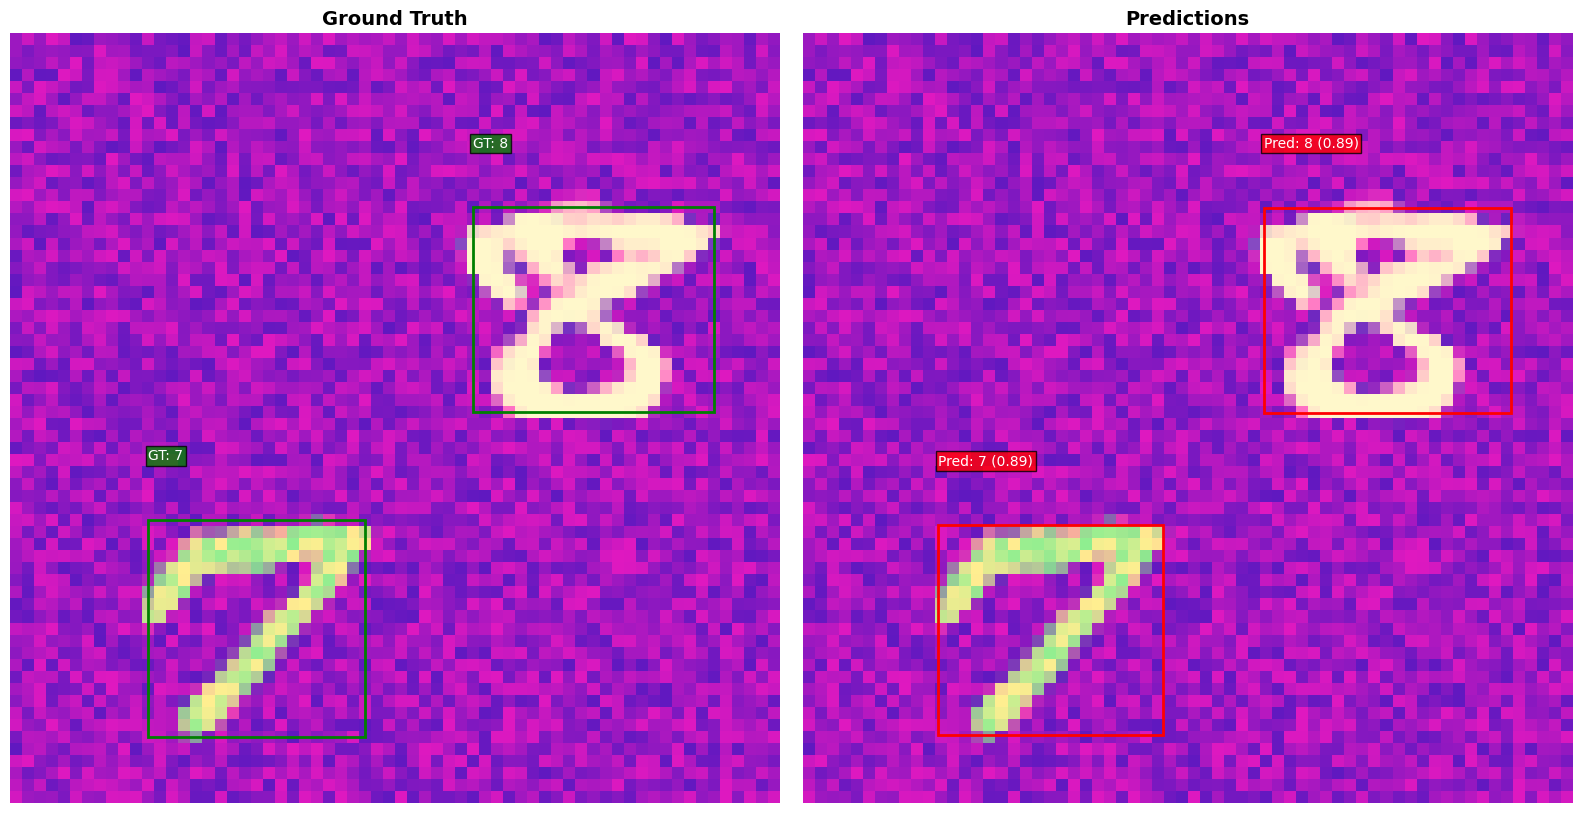


Example 1144:


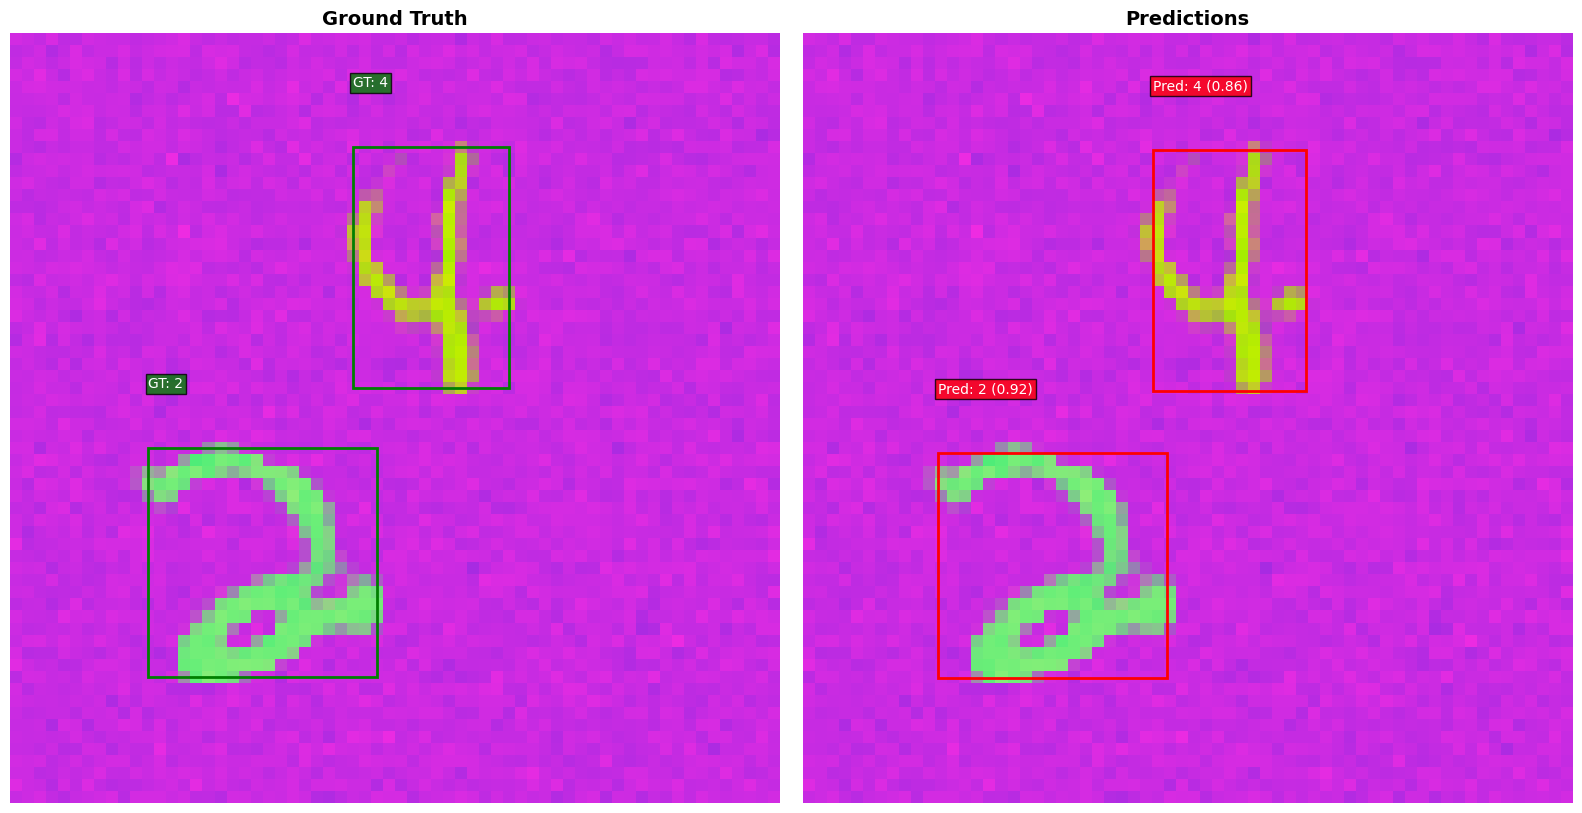


Example 776:


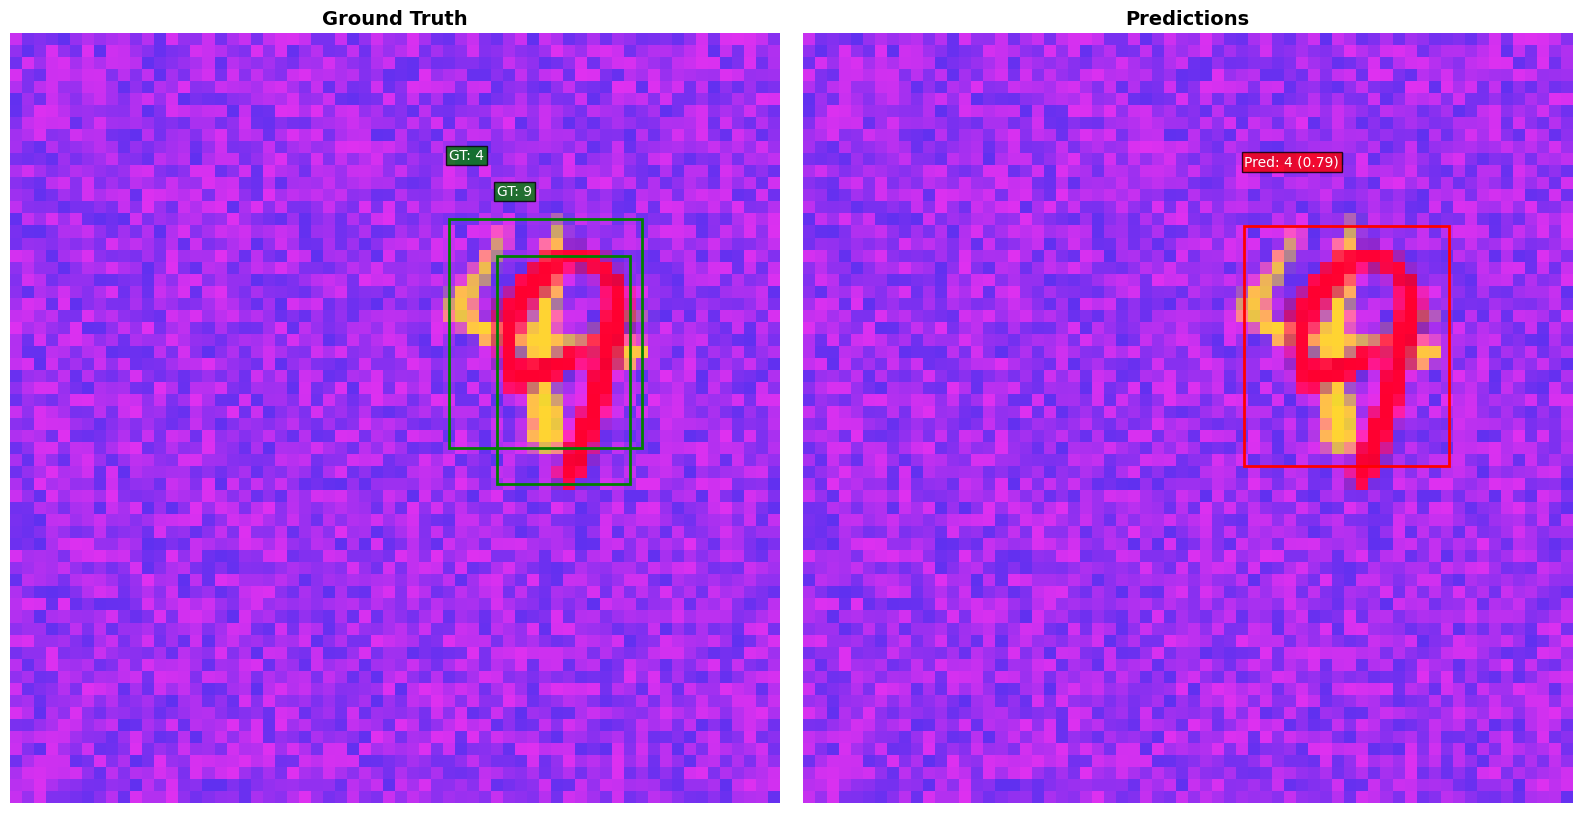


Example 2052:


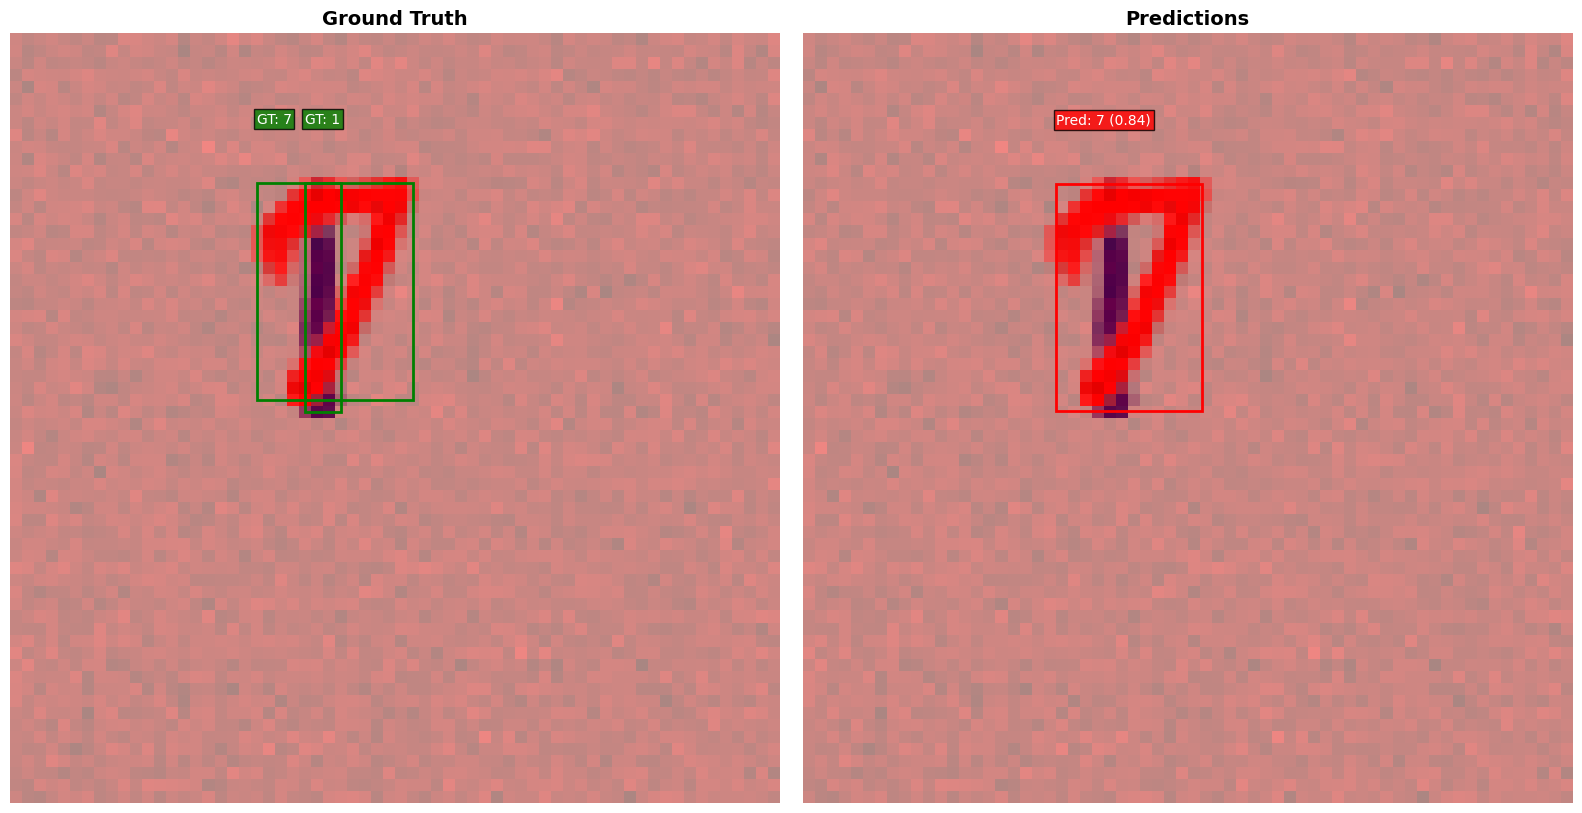


Example 4362:


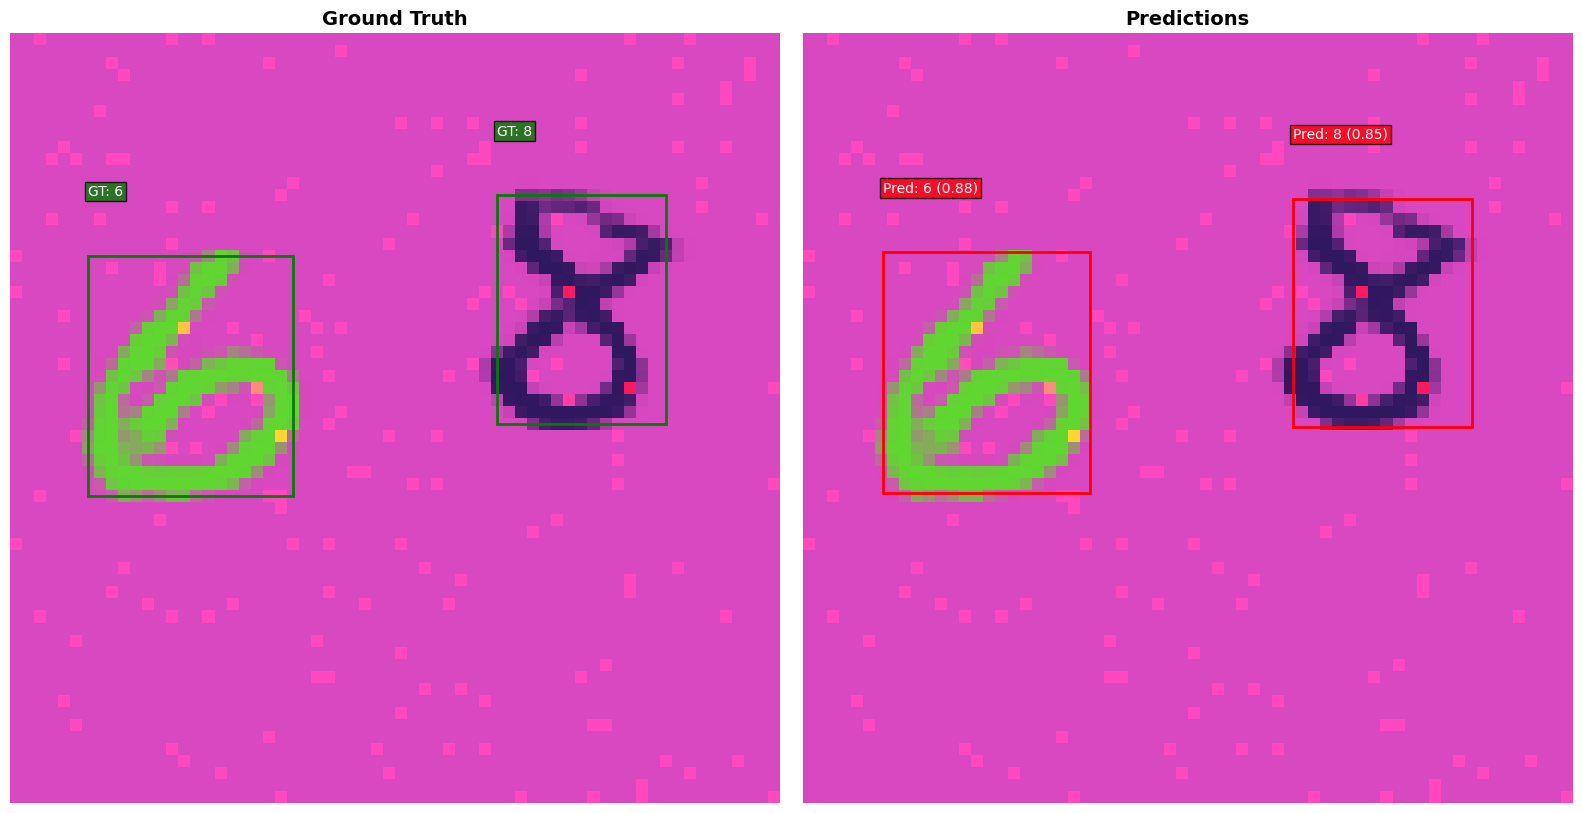

In [20]:
# TODO: show a couple of examples (bounding boxes and labels) of how your model performs on the validation set
# TODO: show a couple of examples (bounding boxes and labels) of how your model performs on the validation set
import random

def show_prediction_example(image_idx, conf_thresh=0.25, nms_thresh=0.45):
    """
    Display a validation image with ground truth and predicted bounding boxes
    """
    # Load image and ground truth
    img_path = os.path.join(val_images_dir, f'{image_idx:05d}.png')
    img = Image.open(img_path).convert('RGB')

    gt_bboxes = val_bboxes[image_idx]
    gt_labels = val_labels[image_idx]

    # Get predictions
    img_tensor = torchvision.transforms.functional.to_tensor(img).unsqueeze(0)
    predict_results = model_eval_full(img_tensor, imgsz=64, conf=conf_thresh, iou=nms_thresh, verbose=False)

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Ground truth
    ax1 = axes[0]
    img_array = np.array(img)
    ax1.imshow(img_array)
    ax1.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax1.axis('off')

    for i, bbox in enumerate(gt_bboxes):
        if torch.all(bbox == 0):
            continue
        x_min, y_min, x_max, y_max = bbox.tolist()
        width = x_max - x_min
        height = y_max - y_min
        if width > 0 and height > 0:
            rect = plt.Rectangle((x_min, y_min), width, height,
                               fill=False, color='green', linewidth=2)
            ax1.add_patch(rect)
            if i < len(gt_labels):
                ax1.text(x_min, y_min-5, f'GT: {gt_labels[i].item()}',
                        bbox={'facecolor': 'green', 'alpha': 0.8, 'pad': 2},
                        fontsize=10, color='white')

    # Predictions
    ax2 = axes[1]
    ax2.imshow(img_array)
    ax2.set_title('Predictions', fontsize=14, fontweight='bold')
    ax2.axis('off')

    if predict_results and predict_results[0].boxes is not None:
        pred_boxes = predict_results[0].boxes.xyxy.cpu().numpy()
        pred_labels = predict_results[0].boxes.cls.cpu().numpy()
        pred_conf = predict_results[0].boxes.conf.cpu().numpy()

        for i, (bbox, label, conf) in enumerate(zip(pred_boxes, pred_labels, pred_conf)):
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min
            rect = plt.Rectangle((x_min, y_min), width, height,
                               fill=False, color='red', linewidth=2)
            ax2.add_patch(rect)
            ax2.text(x_min, y_min-5, f'Pred: {int(label)} ({conf:.2f})',
                    bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 2},
                    fontsize=10, color='white')
    else:
        ax2.text(32, 32, 'No detections', ha='center', va='center',
                bbox={'facecolor': 'red', 'alpha': 0.8}, fontsize=12)

    plt.tight_layout()
    plt.show()

# Show several random examples
print("Showing detection examples on validation set...\n")
random_indices = random.sample(range(len(val_images)), min(5, len(val_images)))

for idx in random_indices:
    print(f"Example {idx}:")
    show_prediction_example(idx, conf_thresh=best_conf, nms_thresh=best_nms)
    print()



The model weights you upload will be run by us (the TAs) on the held-out test set (which will be released _after_ the deadline).